<a href="https://colab.research.google.com/github/R1dhoeee/Deeplearning/blob/main/Model(hyperparameter).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Install dan Import library
!pip install gdown

import gdown
import zipfile
import shutil
import random
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import regularizers


In [2]:
# 2. Download dataset dari Google Drive (gunakan direct link)
file_id = "1Nls_gsE6Nq5hpCBW09o_on8_k924Ityz"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1Nls_gsE6Nq5hpCBW09o_on8_k924Ityz
From (redirected): https://drive.google.com/uc?id=1Nls_gsE6Nq5hpCBW09o_on8_k924Ityz&confirm=t&uuid=2ae55c89-a51b-4d89-a89a-863680878826
To: /content/dataset.zip
100%|██████████| 54.5M/54.5M [00:01<00:00, 32.3MB/s]


'dataset.zip'

In [3]:
# 3. Ekstrak zip
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [4]:
# 4. Split Data sesuai template kamu
original_dataset_dir = Path("dataset/Foto Resizeee")
base_dir = Path("dataset/split_dataset")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

# Buat folder split
for folder in [train_dir, val_dir, test_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Rasio split
val_split = 0.1
test_split = 0.1

# Untuk setiap kelas
for class_dir in original_dataset_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*"))
        random.shuffle(images)

        class_name = class_dir.name
        total = len(images)
        val_count = int(total * val_split)
        test_count = int(total * test_split)
        train_count = total - val_count - test_count

        train_images = images[:train_count]
        val_images = images[train_count:train_count+val_count]
        test_images = images[train_count+val_count:]

        for subset, subset_images in zip(
            [train_dir, val_dir, test_dir],
            [train_images, val_images, test_images]
        ):
            class_subset_dir = subset / class_name
            class_subset_dir.mkdir(parents=True, exist_ok=True)
            for img in subset_images:
                shutil.copy(img, class_subset_dir)


In [5]:
# 5. Data Augmentation
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inisialisasi ImageDataGenerator untuk augmentasi data (opsional)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Tentukan direktori data latih dan validasi
train_dir = 'dataset/split_dataset/train'
val_dir = 'dataset/split_dataset/val'

# Menghasilkan batch data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Selanjutnya, jalankan model Anda


Found 969 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Input layer
input_layer = Input(shape=(224, 224, 3))

# 2. Layer konvolusional
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# 3. Global average pooling
x = GlobalAveragePooling2D()(x)

# 4. Batch normalization dan Dense layers
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# 5. Output layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# 6. Model final
model = Model(inputs=input_layer, outputs=predictions)

# 7. Compile model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# 8. Callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

# 9. Train with maximal 50 epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Sesuai permintaan dosen
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 620ms/step - accuracy: 0.2705 - loss: 1.3941 - val_accuracy: 0.2500 - val_loss: 1.3860 - learning_rate: 1.0000e-05
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 414ms/step - accuracy: 0.3201 - loss: 1.3696 - val_accuracy: 0.4417 - val_loss: 1.3842 - learning_rate: 1.0000e-05
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 444ms/step - accuracy: 0.4059 - loss: 1.3473 - val_accuracy: 0.2500 - val_loss: 1.3813 - learning_rate: 1.0000e-05
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 408ms/step - accuracy: 0.4503 - loss: 1.3326 - val_accuracy: 0.2500 - val_loss: 1.3780 - learning_rate: 1.0000e-05
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - accuracy: 0.5673 - loss: 1.2879 - val_accuracy: 0.2750 - val_loss: 1.3735 - learning_rate: 1.0000e-05
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0.5625 - loss: 1.2739 - val_accuracy: 0.2917 - val_loss: 1.3671 - learning_rate: 1.0000e-05
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step - acc

Saving 20250415_170635.jpg to 20250415_170635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
Gambar: 20250415_170635.jpg
Prediksi: KEYBOARD MCHOOSE


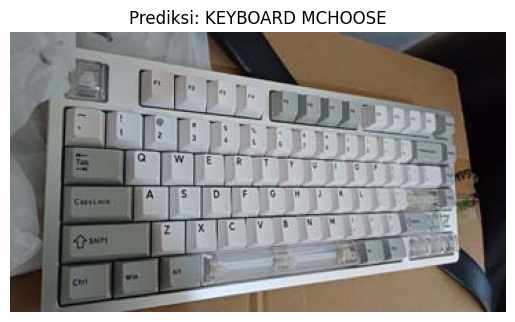

In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

# Upload gambar dari lokal
uploaded = files.upload()

for fname in uploaded.keys():
    img_path = fname
    img = image.load_img(img_path, target_size=(224, 224))  # sesuai input model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # normalisasi

    # Prediksi
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred[0])
    class_names = list(train_generator.class_indices.keys())

    print(f"Gambar: {fname}")
    print(f"Prediksi: {class_names[predicted_class]}")

    # Tampilkan gambar
    plt.imshow(Image.open(img_path))
    plt.title(f"Prediksi: {class_names[predicted_class]}")
    plt.axis("off")
    plt.show()


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inisialisasi ImageDataGenerator untuk data uji
test_datagen = ImageDataGenerator(rescale=1./255)

# Tentukan direktori data uji
test_dir = 'dataset/split_dataset/test'

# Menghasilkan batch data uji
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Found 120 images belonging to 4 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5081 - loss: 0.9562
Test Accuracy: 49.17%


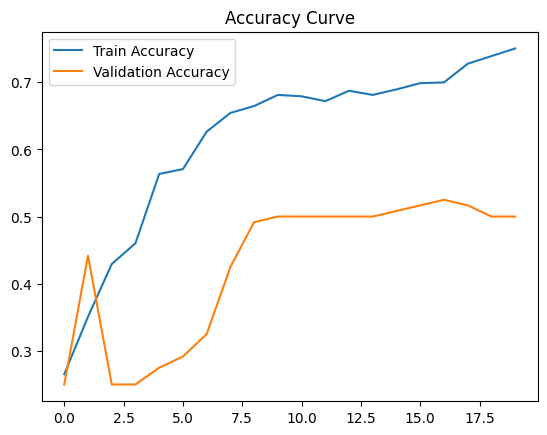

In [15]:
# 10. Visualisasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


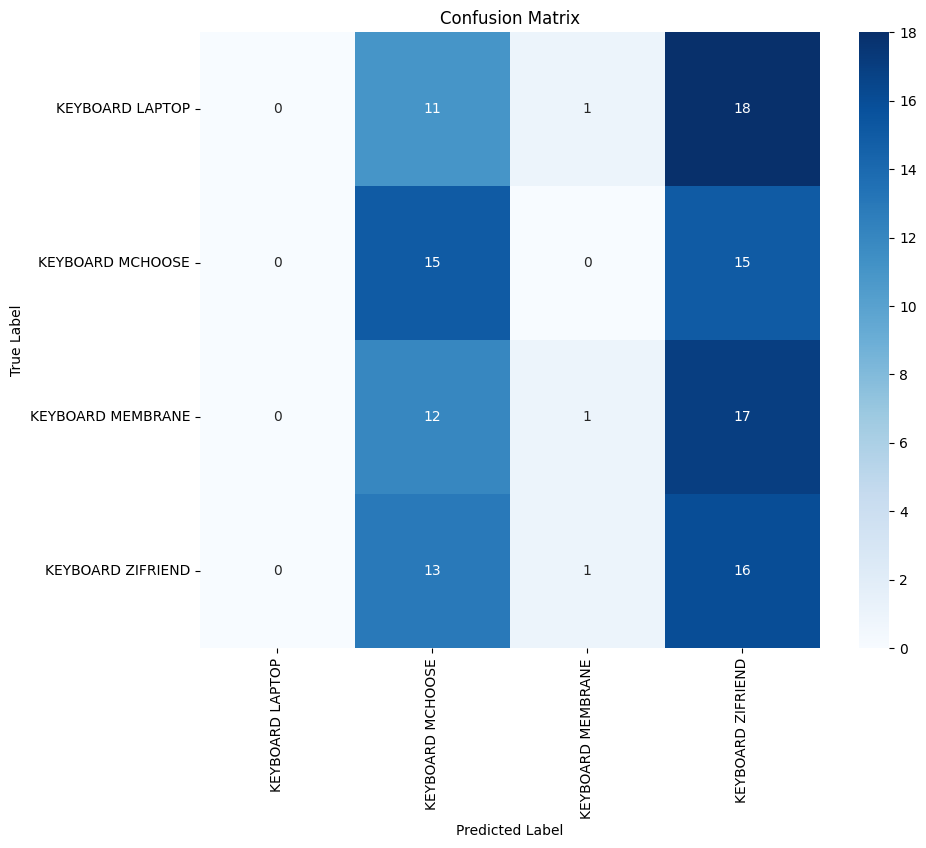


Classification Report:
                   precision    recall  f1-score   support

  KEYBOARD LAPTOP       0.00      0.00      0.00        30
 KEYBOARD MCHOOSE       0.29      0.50      0.37        30
KEYBOARD MEMBRANE       0.33      0.03      0.06        30
KEYBOARD ZIFRIEND       0.24      0.53      0.33        30

         accuracy                           0.27       120
        macro avg       0.22      0.27      0.19       120
     weighted avg       0.22      0.27      0.19       120



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


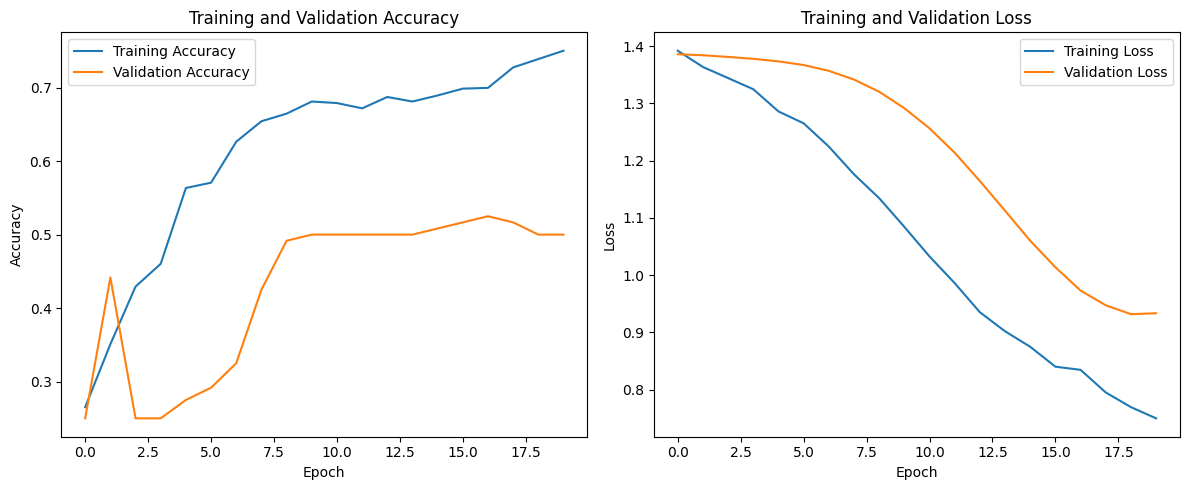

In [16]:
#Evaluasi model dengan confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

#Prediksi pada data test
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

#Dapatkan true classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

#Buat confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#Print classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

#Grafik akurasi dan loss yang lebih lengkap
plt.figure(figsize=(12, 5))

#Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()